## <b>Import libraries<b>

In [208]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score
from sklearn import model_selection
%matplotlib inline
import pickle

In [2]:
#drew inspiration from
#https://github.com/dmesquita/understanding_pytorch_nn and
#https://github.com/msahamed/yelp_comments_classification_nlp/blob/master/word_embeddings.ipynb
#https://github.com/nyu-mll/DS-GA-1011-Fall2017/blob/master/week%20eight/Week%20Eight%20Solutions.ipynb
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#https://github.com/claravania/lstm-pytorch/blob/master/model.py
#https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130
#https://github.com/hpanwar08/sentence-classification-pytorch/blob/master/Sentiment%20analysis%20pytorch.ipynb

In [3]:
#https://medium.com/@martinpella/how-to-use-pre-transfered-word-embeddings-in-pytorch-71ca59249f76

In [4]:
#https://modelzoo.co/model/pytorch-nlp
#http://anie.me/On-Torchtext/
#https://readthedocs.org/projects/pytorchnlp/downloads/pdf/latest/
#https://github.com/A-Jacobson/CNN_Sentence_Classification/blob/master/WordVectors.ipynb

## <b> Data Processing<b>

In [33]:
transfer = pd.read_csv("../clean_tl_data_nn.csv")

In [34]:
train = pd.read_csv("../train_nn.csv")

In [53]:
train = train.loc[train['clean_tweet'].isnull() == False,]

In [35]:
transfer['clean_tweet'][12000]

"its cool its str8 i know y'all got the wrong bitch i understand !"

In [6]:
#create labels

In [29]:
def categorize(x):
    if x == 0:
        return (1)
    else:
        return (0)

In [172]:
transfer['hatespeech'] = [categorize(x) for x in transfer['class']]

In [173]:
transfer['hatespeech'].value_counts()

0    23353
1     1430
Name: hatespeech, dtype: int64

In [20]:
transfer.index

RangeIndex(start=0, stop=24783, step=1)

In [9]:
transfer.reset_index(inplace = True, drop = True)

all_clean_tweets = pd.concat([train.clean_tweet, transfer.clean_tweet])

all_clean_tweets.reset_index(inplace = True, drop = True)

In [73]:
vocab = Counter()

for text in all_clean_tweets:
    for word in text.split(' '):
        vocab[word.lower()]+=1

In [74]:
total_words = len(vocab)

In [139]:
vocab = dict(vocab.most_common(20000))

AttributeError: 'dict' object has no attribute 'most_common'

In [140]:
word2index = {}
index2word = {}

word2index['PAD'] = 0
word2index['UNK'] = 1
index2word[0] = 'PAD'
index2word[1] = 'UNK'

In [141]:
for i,word in enumerate(vocab):
    word2index[word.lower()] = i+2
    index2word[i+2] = word.lower()

In [143]:
len(word2index)

20002

In [144]:
total_words

20002

In [210]:
filename = 'word2index.pkl'
pickle.dump(word2index, open(filename, 'wb'))

In [211]:
filename = 'index2word.pkl'
pickle.dump(index2word, open(filename, 'wb'))

In [145]:
def load_glove(path):
    """
    creates a dictionary mapping words to vectors from a file in glove format.
    """
    with open(path) as f:
        glove = {}
        for line in f.readlines():
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove[word] = vector
        return glove

In [88]:
glove_path = "/Users/carolineroper/Desktop/Capstone Project/Neural Network/glove.twitter.27B/glove.twitter.27B.200d.txt"
%time glove = load_glove(glove_path)

CPU times: user 1min 15s, sys: 14.1 s, total: 1min 29s
Wall time: 1min 45s


In [146]:
matrix_len = total_words
weights_matrix = np.zeros((matrix_len, 200))
words_found = 0

for i in range(0, total_words):
    try: 
        weights_matrix[i] = glove[index2word[i]]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.rand(200)

In [147]:
words_found/total_words #74% of words were found

0.73997600239976

In [148]:
weights_matrix[0] = np.zeros(200) #initialize pad embedding to zero

In [149]:
word2index['hello']

1797

In [150]:
glove['hello']

array([  3.46830010e-01,  -1.96119994e-01,  -3.49229991e-01,
        -2.81580001e-01,  -7.56269991e-01,  -4.00349982e-02,
         5.34219980e-01,   1.53270003e-03,  -2.19630003e-01,
        -5.67080021e-01,  -7.51120001e-02,   3.90740007e-01,
         1.92010000e-01,   4.80460003e-02,  -1.68009996e-01,
        -1.91400006e-01,   1.21619999e-01,  -2.25130007e-01,
         2.22759992e-02,  -2.76320010e-01,   1.07210003e-01,
        -5.81910014e-02,  -1.76540002e-01,  -2.06199996e-02,
        -3.97679992e-02,   1.26190007e-01,   1.89270005e-01,
         1.70169994e-01,  -2.34529991e-02,  -4.23489988e-01,
        -4.26400006e-02,  -2.81010002e-01,  -3.24609995e-01,
         3.08699995e-01,   9.45290029e-02,   1.35590002e-01,
        -5.02489984e-01,   3.00720006e-01,   1.58050001e-01,
         5.50790012e-01,  -3.70050013e-01,  -2.17209995e-01,
        -7.11619973e-01,   4.29749995e-01,  -1.24509996e-02,
        -2.42750004e-01,  -6.29020035e-02,   4.37549986e-02,
         5.90980016e-02,

In [151]:
weights_matrix[1797, ] #confirmed that at index "hello" we're seeing the glove vector for "hello"

array([  3.46830010e-01,  -1.96119994e-01,  -3.49229991e-01,
        -2.81580001e-01,  -7.56269991e-01,  -4.00349982e-02,
         5.34219980e-01,   1.53270003e-03,  -2.19630003e-01,
        -5.67080021e-01,  -7.51120001e-02,   3.90740007e-01,
         1.92010000e-01,   4.80460003e-02,  -1.68009996e-01,
        -1.91400006e-01,   1.21619999e-01,  -2.25130007e-01,
         2.22759992e-02,  -2.76320010e-01,   1.07210003e-01,
        -5.81910014e-02,  -1.76540002e-01,  -2.06199996e-02,
        -3.97679992e-02,   1.26190007e-01,   1.89270005e-01,
         1.70169994e-01,  -2.34529991e-02,  -4.23489988e-01,
        -4.26400006e-02,  -2.81010002e-01,  -3.24609995e-01,
         3.08699995e-01,   9.45290029e-02,   1.35590002e-01,
        -5.02489984e-01,   3.00720006e-01,   1.58050001e-01,
         5.50790012e-01,  -3.70050013e-01,  -2.17209995e-01,
        -7.11619973e-01,   4.29749995e-01,  -1.24509996e-02,
        -2.42750004e-01,  -6.29020035e-02,   4.37549986e-02,
         5.90980016e-02,

In [152]:
len(vocab.keys())

20000

In [153]:
weights_matrix.shape

(20002, 200)

In [154]:
def pad_data(s, length):
    padded = np.zeros((length,), dtype = np.int64)
    if len(s) > length: 
        padded = s[:length]
    else:
        padded[:len(s)] = s
    return np.array(padded)

In [155]:
transfer['clean_tweet'][3]

'! ! ! ! ! ! ! ! ! _g_anderson : _based she look like a tranny'

In [159]:
def get_index(x):
    try:
        return word2index[x]
    except KeyError:
        return 1

In [161]:
transfer['seq_len'] = [len(x.split(' ')) for x in transfer['clean_tweet']]

transfer['numeric'] = [[get_index(y) for y in x.split(' ')] for x in transfer['clean_tweet']]

transfer['padded_tweet'] = [pad_data(x, 25) for x in transfer.numeric]

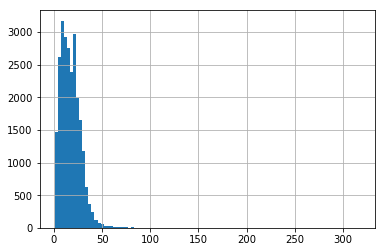

In [164]:
transfer.seq_len.hist(bins = 100)

In [166]:
# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df, label, maxlen=20):
        self.df = df
        self.label = label

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.padded_tweet[idx]
        y = self.df[self.label][idx]
        lens = self.df.seq_len[idx]
        return X,y,lens

In [167]:
data = VectorizeData(transfer, label = 'hatespeech')

dl = DataLoader(data, batch_size = 32, shuffle = True)

In [184]:
transfer['hatespeech'].value_counts()

0    23353
1     1430
Name: hatespeech, dtype: int64

In [185]:
1430/23353

0.06123410268487989

In [168]:
class LSTMClassifier(nn.Module):
    def __init__(self, weights, vocab_size, embedding_dim, hidden_dim, output_size, batch_size):
        super(LSTMClassifier, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(self.weights)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)
        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax()
        self.dropout_layer = nn.Dropout(p=0.2)
        self.batch_size = batch_size
    
    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)), \
               autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))

    def forward(self, batch):
        self.hidden = self.init_hidden(batch_size)
        embeds = self.embedding(batch) 
        #packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(embeds, self.hidden)
        # ht is the last hidden state of the sequences
        # ht = (1 x batch_size x hidden_dim)
        # ht[-1] = (batch_size x hidden_dim)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)
        return output

In [189]:
hidden_size = 200 
num_classes = 2
learning_rate = 0.005
num_epochs = 2
batch_size = 32
weights = torch.FloatTensor(weights_matrix)

In [175]:
transfer.hatespeech.value_counts()

0    23353
1     1430
Name: hatespeech, dtype: int64

In [186]:
total_words

20002

In [201]:
net = LSTMClassifier(weights, total_words, hidden_size, hidden_size, num_classes, batch_size)

# Loss and Optimizer
criterion = nn.NLLLoss(weight = torch.Tensor([.06,1]))  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

losses = []

In [202]:
num_epochs = 5

num_batch = len(dl) - 1
# transfer the Model
for epoch in range(num_epochs):
    it = iter(dl)
    # Loop over all batches
    for i in range(num_batch):
        batch_x,batch_y,batch_len = next(it)
        tweets = Variable(batch_x.transpose(0,1))
        labels = Variable(batch_y)
        lengths = Variable(batch_len)
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(tweets)
        loss = criterion(outputs, labels)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(transfer.clean_tweet)//batch_size, loss.data[0]))

Epoch [1/5], Step [4/774], Loss: 0.8619
Epoch [1/5], Step [8/774], Loss: 0.7357
Epoch [1/5], Step [12/774], Loss: 0.7169
Epoch [1/5], Step [16/774], Loss: 0.7117
Epoch [1/5], Step [20/774], Loss: 0.9054
Epoch [1/5], Step [24/774], Loss: 0.7216
Epoch [1/5], Step [28/774], Loss: 0.7002
Epoch [1/5], Step [32/774], Loss: 0.6475
Epoch [1/5], Step [36/774], Loss: 0.6830
Epoch [1/5], Step [40/774], Loss: 0.5765
Epoch [1/5], Step [44/774], Loss: 1.0086
Epoch [1/5], Step [48/774], Loss: 0.5670
Epoch [1/5], Step [52/774], Loss: 0.7761
Epoch [1/5], Step [56/774], Loss: 0.8844
Epoch [1/5], Step [60/774], Loss: 0.7536
Epoch [1/5], Step [64/774], Loss: 1.1917
Epoch [1/5], Step [68/774], Loss: 0.6692
Epoch [1/5], Step [72/774], Loss: 0.7396
Epoch [1/5], Step [76/774], Loss: 0.6005
Epoch [1/5], Step [80/774], Loss: 0.6314
Epoch [1/5], Step [84/774], Loss: 0.8198
Epoch [1/5], Step [88/774], Loss: 0.6671
Epoch [1/5], Step [92/774], Loss: 0.4528
Epoch [1/5], Step [96/774], Loss: 0.9378
Epoch [1/5], Step 

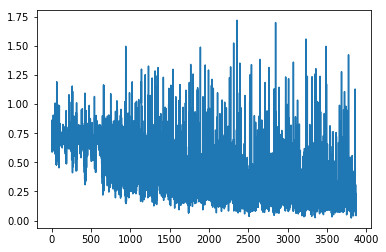

In [203]:
plt.plot(losses) #trained at lr of 0.01 for 2 epochs

In [206]:
predictions = []
pred_labels = []
#get training predictions and training f-score
it = iter(dl)
num_batch = len(dl) - 1
# Loop over all batches
for i in range(num_batch):
    batch_x,batch_y,batch_len = next(it)
    tweets = Variable(batch_x.transpose(0,1))
    labels = Variable(batch_y)
    lengths = Variable(batch_len)
    outputs = net(tweets)
    _, pred = torch.max(outputs.data, 1)
    predictions.extend(list(pred.numpy()))
    pred_labels.extend(list(labels.data.numpy()))
f1_score(predictions, pred_labels) #almost .6

0.59859950304946907

In [209]:
filename = 'model_for_transfer_learning.sav'
pickle.dump(net, open(filename, 'wb'))